# 改行・読点挿入モデル 学習ノートブック


## Mount


In [1]:
from google.colab import drive

drive.mount("/content/drive")


Mounted at /content/drive


## Libraries


In [2]:
!pip install transformers
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 32.9 MB/s 
     |████████████████████████████████| 7.6 MB 71.1 MB/s 
     |████████████████████████████████| 182 kB 76.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import torch
from transformers import BertModel
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
import numpy as np
from torchinfo import summary
import time
import datetime
from transformers import get_linear_schedule_with_warmup
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
import os
from tqdm.notebook import tqdm 
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader


## Pre Trained Model


In [4]:
# we must use the same tokenizer as the one used to train the model
# 日本語のBERTモデルは、ct-tohokuのものが一般的 中でもこのモデルが精度でやすいらしい
PRETRAINED_MODEL_NAME = "cl-tohoku/bert-base-japanese-whole-word-masking"  


## GPU


In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("There are %d GPU(s) available." % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Dataset


### Load


In [8]:
TRAIN_DATASET_PATH = "/content/drive/MyDrive/MurataLab/newline/train_dataset.csv"


In [9]:
df = pd.read_csv(TRAIN_DATASET_PATH)
print(f"Dataset Length: {len(df)}")
df.sample(10)


Dataset Length: 22158


,Unnamed: 0,input,is_line_feed,is_comma,is_period
3532,3532,果たしている[ANS]そういった,1,0,1
18096,18096,乗っていて[ANS]よく,0,0,0
9521,9521,今度は[ANS]恐いもの知らずで,0,1,0
6401,6401,あるはずなんです[ANS]日本は,1,0,1
14621,14621,ボタンを[ANS]押している,0,0,0
12558,12558,車検という[ANS]節目が,0,0,0
1613,1613,発言[ANS]意見が,0,0,0
15915,15915,最後に[ANS]新郎新婦から,0,0,0
18317,18317,ぷつんと[ANS]切れましたので,0,0,0
15825,15825,行いました[ANS]私の,1,0,1


In [10]:
inputs = df.input.values
labels = df.is_line_feed.values.astype(np.int64)  # FIXME: use lf and comma


### Tokenizer


In [11]:
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
tokenizer.add_tokens(["[ANS]"])


Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


('/content/drive/MyDrive/MurataLab/newline/models/20221228_102048/tokenizer_config.json',
 '/content/drive/MyDrive/MurataLab/newline/models/20221228_102048/special_tokens_map.json',
 '/content/drive/MyDrive/MurataLab/newline/models/20221228_102048/vocab.txt',
 '/content/drive/MyDrive/MurataLab/newline/models/20221228_102048/added_tokens.json')

In [12]:
print("Original: ", inputs[0])
print("Tokenized: ", tokenizer.tokenize(inputs[0]))
print("Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(inputs[0])))


Original:  おはようございます[ANS]ただ今
Tokenized:  ['おはよう', '##ご', '##ざい', '##ます', '[ANS]', 'ただ', '今']
Token IDs:  [21119, 29066, 18526, 11665, 32000, 909, 744]


### Max Length


In [13]:
dataset_max_length = 0
for sentence in inputs:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    dataset_max_length = max(dataset_max_length, len(input_ids))

print("Max sentence length: ", dataset_max_length)


Max sentence length:  26


In [14]:
MAX_LENGTH = 32  # at least dataset_max_length + 2 is better


### Tokenize


In [ ]:
def preprocess(inputs, labels):
    input_ids = []
    attention_masks = []

    for input in inputs:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            input,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=MAX_LENGTH,  # Pad & truncate all sentences.
            pad_to_max_length=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors="pt",  # Return pytorch tensors.
        )

        input_ids.append(encoded_dict["input_ids"])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    labels = torch.tensor(labels, dtype=torch.int64)
    
    return input_ids, attention_masks, labels

In [15]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids, attention_masks, labels = preprocess(inputs, labels) 
print("Original: ", inputs[0])
print("Token IDs:", input_ids[0])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  おはようございます[ANS]ただ今
Token IDs: tensor([    2, 21119, 29066, 18526, 11665, 32000,   909,   744,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])


### Split Dataset


In [16]:
TRAIN_DATASET_RATIO = 0.9

# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
BATCH_SIZE = 16


In [17]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(TRAIN_DATASET_RATIO * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print("{:>5,} training samples".format(train_size))
print("{:>5,} validation samples".format(val_size))


19,942 training samples
2,216 validation samples


In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


## Train


### Model


In [19]:
model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME,
    num_labels=2,  # The number of output labels--2 for binary classification.
    output_attentions=False,  # Whether the model returns attentions weights.
    output_hidden_states=False,  # Whether the model returns all hidden-states.
)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
if torch.cuda.is_available():
    model.cuda()


Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

In [20]:
summary(model, depth=4)


Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              24,576,768
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             --
│    │    │    └─BertLayer: 4-1                         7,087,872
│    │    │    └─BertLayer: 4-2                         7,087,872
│    │    │    └─BertLayer: 4-3                         7,087,872
│    │    │    └─BertLayer: 4-4                         7,087,872
│    │    │    └─BertLayer: 4-5                         7,087,8

### Optimizer


In [21]:
LEARNING_RATE = 2e-5  # default is 5e-5
EPSILON = 1e-8


In [22]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    eps=EPSILON,
)


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Epoch


In [62]:
# The BERT authors recommend between 2 and 4.
EPOCHS = 4


### Scheduler


In [63]:
# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # Default value in run_glue.py (https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128)
    num_training_steps=total_steps,
)


### Function


In [64]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [65]:
def format_time(elapsed):
    """
    Takes a time in seconds and returns a string hh:mm:ss
    """
    return str(datetime.timedelta(seconds=int(round((elapsed)))))


In [66]:
def save_model(model, dir, filename):
    print("Saving model to %s" % os.path.join(dir, filename))
    torch.save(model.to("cpu").state_dict(), os.path.join(dir, filename))
    model.to("cuda")
    return os.path.join(dir, filename)


In [67]:
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

    # ネットワークの形が固定のとき、GPU側でネットワークの計算を最適化し高速にしてくれる
    # ただし、再現性がなくなるため、Falseとする
    torch.backends.cudnn.benchmark = False


In [ ]:
def make_output_dir():
    now = datetime.datetime.now() + datetime.timedelta(hours=9)
    now = now.strftime("%Y%m%d_%H%M%S")
    dir_name = f"/content/drive/MyDrive/MurataLab/newline/models/{now}"
    os.makedirs(dir_name)
    return dir_name


### Run


In [68]:
SEED = 40


In [69]:
OUTPUT_DIR = make_output_dir()
tokenizer.save_pretrained(OUTPUT_DIR)

fix_seed(SEED)

training_stats = []
total_t0 = time.time()
best_filepath = None

for epoch_i in range(0, EPOCHS):
    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.
    print("")
    print("======== Epoch {:} / {:} ========".format(epoch_i + 1, EPOCHS))
    print("Training...")

    t0 = time.time()
    total_train_loss = 0

    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            # 1つ前のバッチの損失を表示
            print(
                "  Batch {:>5,}  of  {:>5,}.   Loss: {:>7.4f}.   Elapsed: {:}.".format(
                    step, len(train_dataloader), loss, elapsed
                )
            )

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels,
        )
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    filepath = save_model(
        model,
        OUTPUT_DIR,
        f"model_{epoch_i + 1}_valacc_{str(round(avg_val_accuracy, 3)).replace('.','-')}_valloss_{str(round(avg_val_loss, 3)).replace('.','-')}.pth",
    )
    if (
        best_filepath is None
        or avg_val_loss
        < min(training_stats, key=lambda x: x["Valid. Loss"])["Valid. Loss"]
    ):
        best_filepath = filepath

    training_stats.append(
        {
            "epoch": epoch_i + 1,
            "Training Loss": avg_train_loss,
            "Valid. Loss": avg_val_loss,
            "Valid. Accur.": avg_val_accuracy,
            "Training Time": training_time,
            "Validation Time": validation_time,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,247.   Loss:  0.0648.   Elapsed: 0:00:04.
  Batch    80  of  1,247.   Loss:  0.4320.   Elapsed: 0:00:09.
  Batch   120  of  1,247.   Loss:  0.0771.   Elapsed: 0:00:14.
  Batch   160  of  1,247.   Loss:  0.1644.   Elapsed: 0:00:18.
  Batch   200  of  1,247.   Loss:  0.8264.   Elapsed: 0:00:23.
  Batch   240  of  1,247.   Loss:  0.5200.   Elapsed: 0:00:27.
  Batch   280  of  1,247.   Loss:  0.1975.   Elapsed: 0:00:31.
  Batch   320  of  1,247.   Loss:  0.2407.   Elapsed: 0:00:36.
  Batch   360  of  1,247.   Loss:  0.0075.   Elapsed: 0:00:40.
  Batch   400  of  1,247.   Loss:  0.0099.   Elapsed: 0:00:45.
  Batch   440  of  1,247.   Loss:  0.2268.   Elapsed: 0:00:50.
  Batch   480  of  1,247.   Loss:  0.1569.   Elapsed: 0:00:54.
  Batch   520  of  1,247.   Loss:  0.1594.   Elapsed: 0:00:59.
  Batch   560  of  1,247.   Loss:  0.0249.   Elapsed: 0:01:03.
  Batch   600  of  1,247.   Loss:  0.3492.   Elapsed: 0:01:08.
  Batch   64

### Result


In [70]:
# Display floats with two decimal places.
pd.set_option("precision", 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index("epoch")
df_stats


,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.25,0.43,0.84,0:02:23,0:00:04
2,0.30,0.41,0.84,0:02:31,0:00:04
3,0.23,0.52,0.84,0:02:29,0:00:04
4,0.17,0.68,0.83,0:02:32,0:00:06


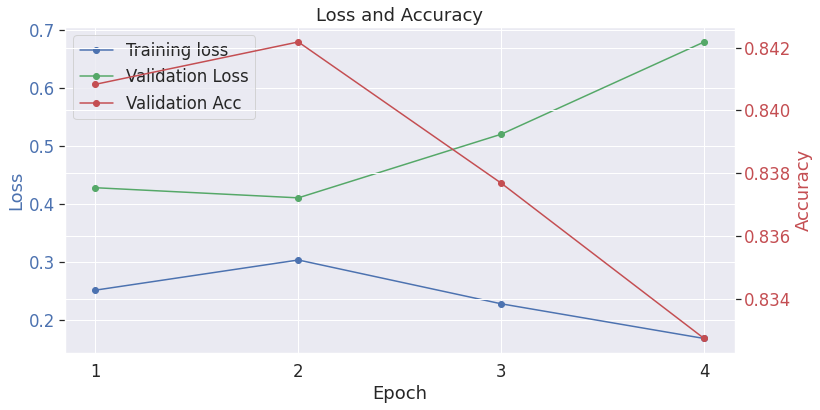

In [83]:
sns.set(style="darkgrid")
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(df_stats["Training Loss"], "b-o", label="Training loss")
ax1.plot(df_stats["Valid. Loss"], "g-o", label="Validation Loss")
ax1.set_ylabel("Loss", color="b")
ax1.tick_params(axis="y", labelcolor="b")

ax2.plot(df_stats["Valid. Accur."], "r-o", label="Validation Acc")
ax2.set_ylabel("Accuracy", color="r")
ax2.tick_params(axis="y", labelcolor="r")

ax1.set_xlabel("Epoch")
ax1.set_xticks([1, 2, 3, 4])

plt.title("Loss and Accuracy")

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc="upper left")

plt.show()


## Test


### Load Dataset & Preprosecc


In [72]:
TEST_DATASET_PATH = "/content/drive/MyDrive/MurataLab/newline/test_dataset.csv"


In [84]:
df = pd.read_csv(TEST_DATASET_PATH)
print("Number of test sentences: {:,}\n".format(df.shape[0]))

sentences = df.input.values
labels = df.is_line_feed.values.astype(np.int64)  # FIXME

input_ids = []
attention_masks = []

for sentence in sentences:
    encoded_dict = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    input_ids.append(encoded_dict["input_ids"])
    attention_masks.append(encoded_dict["attention_mask"])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(
    prediction_data, sampler=prediction_sampler, batch_size=batch_size
)


Number of test sentences: 1,424



/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [85]:
print("Predicting labels for {:,} test sentences...".format(len(input_ids)))

model.load_state_dict(torch.load(best_filepath))

predictions, true_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    predictions.append(logits)
    true_labels.append(label_ids)


Predicting labels for 1,424 test sentences...


### Positive Sample Count


In [86]:
print(
    "Positive samples: %d of %d (%.2f%%)"
    % (
        df.is_line_feed.sum(),
        len(df.is_line_feed),
        (df.is_line_feed.sum() / len(df.is_line_feed) * 100.0),
    )
)


Positive samples: 470 of 1424 (33.01%)


### MCC

- マシューズ相関係数=MCC（Matthews Correlation Coefficient）
- ２値分類モデルの精度をみる指標
- +1 の係数は完全予測を表し、0 は平均ランダム予測を表し、-1 は逆予測を表す


In [87]:
matthews_set = []

print("Calculating Matthews Corr. Coef. for each batch...")

for i in range(len(true_labels)):
    # The predictions for this batch are a 2-column ndarray (one column for "0"
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)


Calculating Matthews Corr. Coef. for each batch...


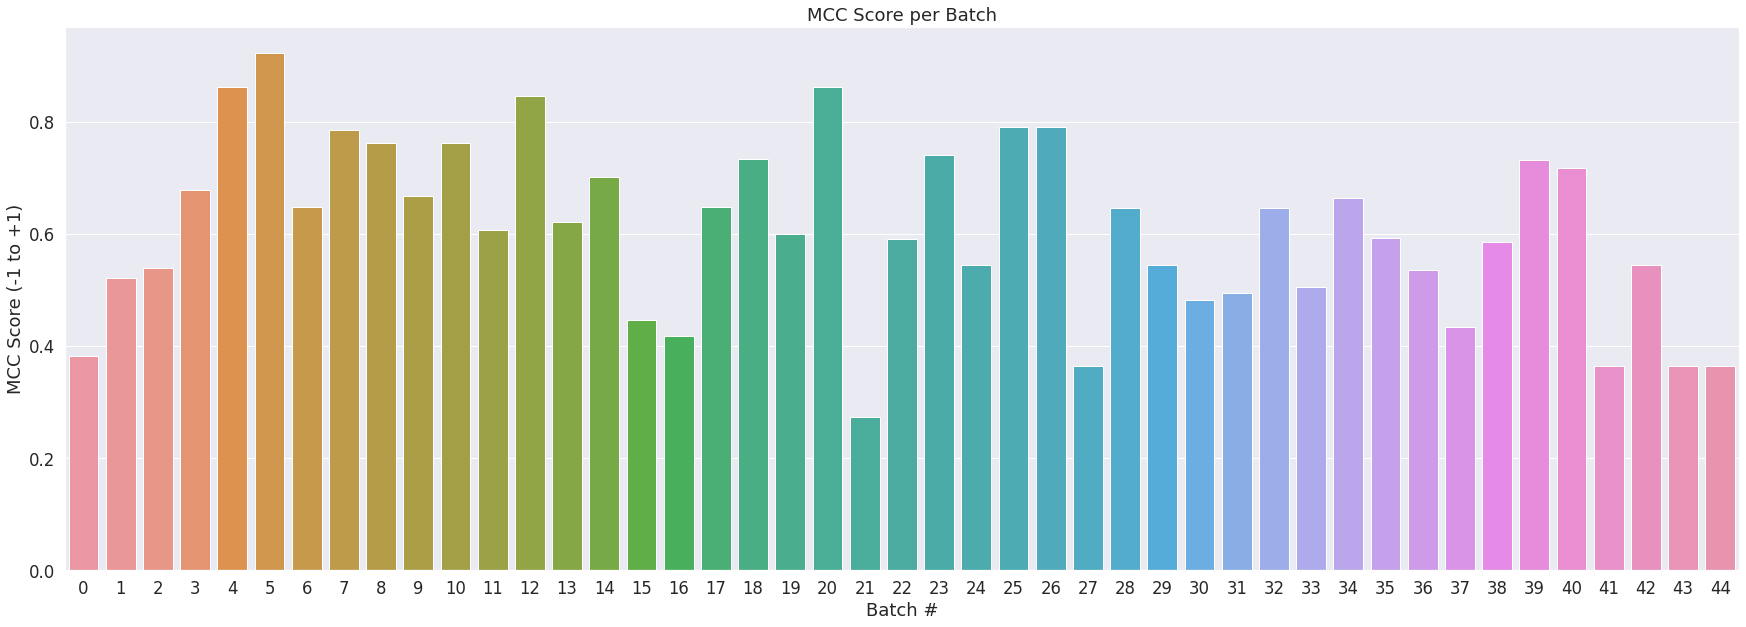

In [94]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title("MCC Score per Batch")
plt.ylabel("MCC Score (-1 to +1)")
plt.xlabel("Batch #")

plt.rcParams["figure.figsize"] = (30, 20)
plt.show()


In [89]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print("Total MCC: %.3f" % mcc)


Total MCC: 0.606


### 混同行列

- 真陽性（TP: True Positive）: 実際のクラスが陽性で予測も陽性（正解）
- 真陰性（TN: True Negative）: 実際のクラスが陰性で予測も陰性（正解）
- 偽陽性（FP: False Positive）: 実際のクラスは陰性で予測が陽性（不正解）
- 偽陰性（FN: False Negative）: 実際のクラスは陽性で予測が陰性（不正解）

```sh
                                    Predicted
                            Negative  Positive
Actual Negative     TN        FP
            Positive      FN        TP
```


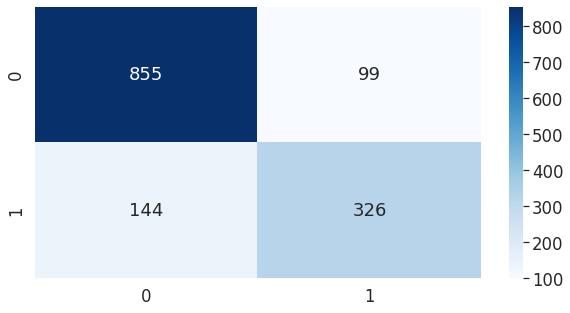

In [90]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    confusion_matrix(flat_true_labels, flat_predictions),
    annot=True,
    cmap="Blues",
    fmt="d",
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR), "confusion_matrix.png")


### 評価指標

- 適合率(precision): 陽性と予測されたサンプルのうち正解したサンプルの割合

  $$
  precision = \frac{TP}{TP + FP}
  $$

- 再現率(recall): 実際に陽性のサンプルのうち正解したサンプルの割合

  $$
  recall = \frac{TP}{TP + FN}
  $$

- F1 値(F1-measure): 適合率と再現率の調和平均

  $$
  F1measure = \frac{2 * precision * recall}{precision + recall}
  $$

- macro avg: 陽性・陰性を入れ替えて算出した 2 つの値の算術平均
- weighted avg: 陽性・陰性を変えて算出した 2 つの値の加重平均

cf. https://note.nkmk.me/python-sklearn-confusion-matrix-score/


In [1]:
pd.DataFrame(
    classification_report(flat_true_labels, flat_predictions, output_dict=True)
)
df.to_csv()


NameError: ignored

### 全文可視化


In [92]:
for i, sentence in enumerate(sentences):
    text, _ = sentence.split("[ANS]")
    print(text, end="")
    if flat_predictions[i] == 1:
        print()
    elif flat_true_labels[i] == 1:
        print(" (x) ", end="")

print(sentences[-1].split("[ANS]")[1])


議長
どうもありがとうございました
只今ご紹介いただきました
木村でございます
本日はここ名古屋市にお招きいただきまして
環境問題の国際的動向と地域からの (x) 取り組みについて
報告する機会を与えられ (x) 大変光栄に思っております
まず最初に (x) 本会議のホストであります
名古屋市長に (x) 心から御礼を申し上げたいと思います
昨日来市長が先頭に立たれまして
私どもいろいろと案内していただき
そして (x) 名古屋市についてご説明いただきました
非常にバイタリティ溢れ (x) 若さと行動力と
それから (x) リーダーシップ大なりということで
お見受けするところ
平成の徳川家康のような方ではないかと
密かに思っておる次第でございます
それから中村さんを始めとする (x) 本会議主催者の皆様にも (x) 御礼申し上げたいと思います
私はこの度名古屋市に初めて参りました
従いまして (x) あまり予備知識はございませんでした
徳川家康のことそれから (x) 小さい頃読みました童話集ですね
そういった童話を読んだ記憶が (x) かすかにございます
非常に (x) 池田市旧池田市大川市については
例えば池田市は
大変雪が多い土地だという (x) そういう程度の知識しかございませんでした
昨日は池田城の桜の美しい姿などを (x) 見せていただきまして
認識を新たにしたところでございます
本日は主として三つのことを (x) 報告したいと思っております
第一点は
今年が地球環境の年であるということでございます
それから第二点日本の役割と (x) 特に東アジアでの環境分野での協力についてであります
第三点は地域からの取り組み
すなわちローカル・イニシアティブについてでございます
こういった本題に入ります
前にすみません
二つほどエピソードを (x) 紹介させていただきたいと思います
最初のエピソードはですね
ゆで蛙のエピソードと言います
ゆで蛙蛙をゆでると言います
ちょっと残酷でありますが
これはアメリカの副大統領ゴア副大統領
アルバーさんの書いた本がございます
千九百九十二年に発行されております
非常に立派な本がございます
この本にエピソードが載っておりますが
蛙をですね蛙を熱いお湯に放り込むと
熱さに驚いて飛び出すそうです
ところが最初にぬるま湯に浸けてですね
そ